# Oscillation in eeg 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import warnings 
import seaborn as sns
import scipy as sp
import numpy as np 


import mne 

warnings.filterwarnings('ignore')

In [3]:
sampling_rate = 250 # in seconds
time = 1/sampling_rate
unit_time = 's'

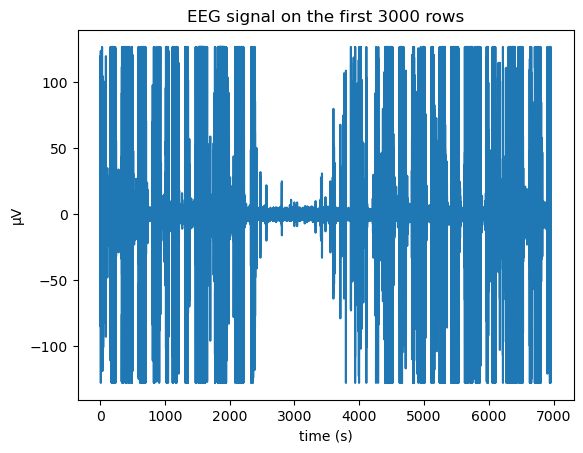

In [4]:
df = pd.read_csv('../data/EEGArchi13mPFC.txt')
# df = df.iloc[int(start*20_000):int(end*20_000)] 
df['time'] = df.index * time
df.rename(columns={'0': 'µV'}, inplace=True)
plt.plot(df['time'], df['µV'])
plt.xlabel(f'time ({unit_time})')
plt.ylabel('µV')
plt.title('EEG signal on the first 3000 rows')
plt.savefig("./figures/EEG_signal_all_data.png")
plt.show()

## 1 Plot on the first part of the experiment (before the gap)

In [5]:
def four_s_cutting(path = '../data/EEGArchi13mPFC.txt') : 
    df = pd.read_csv(path)
    df['time'] = df.index * time
    df.rename(columns={'0': 'mV'}, inplace=True)
    df = df.iloc[int(0*sampling_rate):int(2000*sampling_rate)]
    res = []
    for i in range(0,len(df),1000) :
        try : 
            df_red = df.iloc[i:i+1000]
        except : 
            df_red = df.iloc[i:]

        res.append(df_red)
    return res

### 1.2 Plot with mne 

Creating RawArray with float64 data, n_channels=500, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


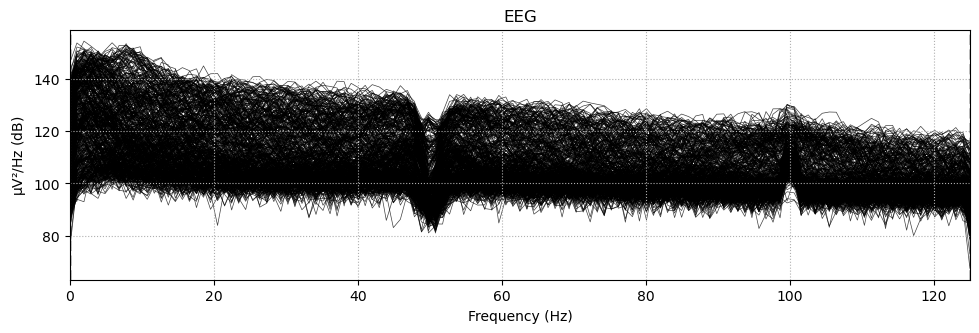

In [6]:
data_cut = four_s_cutting()
data = np.array([data_cut[i]["mV"] for i in range(len(data_cut))]) ## All the data
# data = np.array([data_cut[i]["mV"] for i in range(50)])
info = mne.create_info(ch_names=['eeg']*500,
                       ch_types=['eeg']*500,
                       sfreq=sampling_rate)

simulated_raw = mne.io.RawArray(data, info)
simulated_raw.plot_psd()

## 2. Filtering 

### 2.1 Filter superslow waves 

Creating RawArray with float64 data, n_channels=500, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


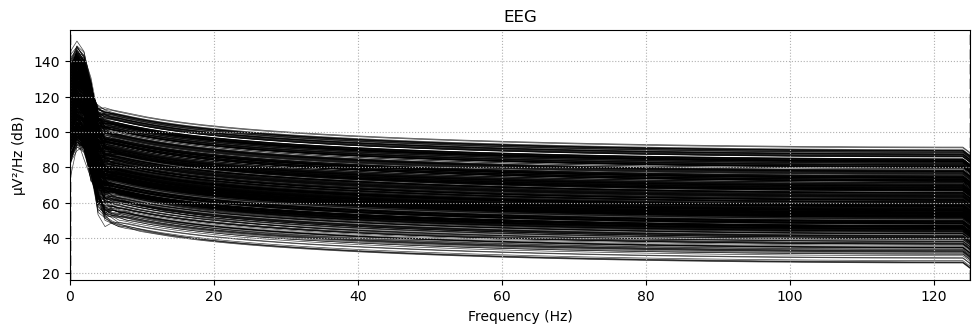

In [7]:
plt.close('all')
def filter_data(data, low, high, sampling_rate) : 
    filtered_data = []
    for i in range(len(data)) : 
        filtered_data.append(sp.signal.filtfilt(sp.signal.butter(3, [low, high], btype='bandpass', fs=sampling_rate)[0], sp.signal.butter(3, [low, high], btype='bandpass', fs=sampling_rate)[1], data[i]))
    return np.array(filtered_data)
data_f = filter_data(data, 0.00001, 1.5, sampling_rate)
simulated_raw_filterd = mne.io.RawArray(data_f, info)
simulated_raw_filterd.plot_psd()

### 2.2 Filter theta waves

Creating RawArray with float64 data, n_channels=500, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


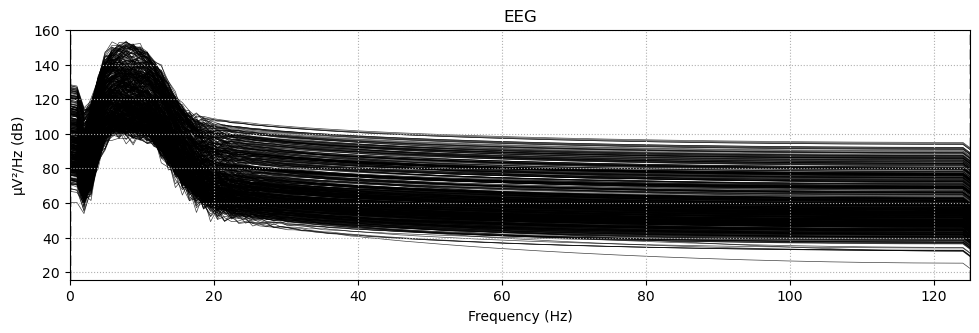

In [8]:
plt.close('all')
data_f = filter_data(data, 5, 12, sampling_rate)
simulated_raw_filterd = mne.io.RawArray(data_f, info)
simulated_raw_filterd.plot_psd()

### 2.3 Filter gamma waves

Creating RawArray with float64 data, n_channels=500, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


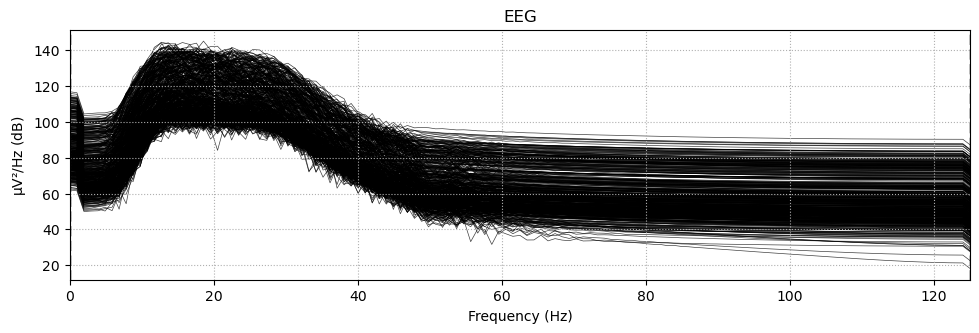

In [9]:
plt.close('all')
data_f = filter_data(data, 12,30, sampling_rate)
simulated_raw_filterd = mne.io.RawArray(data_f, info)
simulated_raw_filterd.plot_psd()

### 2.4 Filter superfast waves

Creating RawArray with float64 data, n_channels=500, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


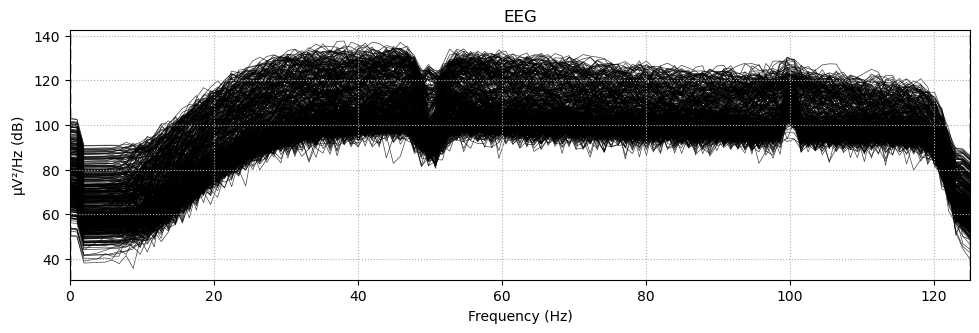

In [10]:
plt.close('all')
data_f = filter_data(data,30,120, sampling_rate)
simulated_raw_filterd = mne.io.RawArray(data_f, info)
simulated_raw_filterd.plot_psd()

### 2.5 plot all the filter on the same graph

Creating RawArray with float64 data, n_channels=500, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
Creating RawArray with float64 data, n_channels=500, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
Creating RawArray with float64 data, n_channels=500, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
Creating RawArray with float64 data, n_channels=500, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


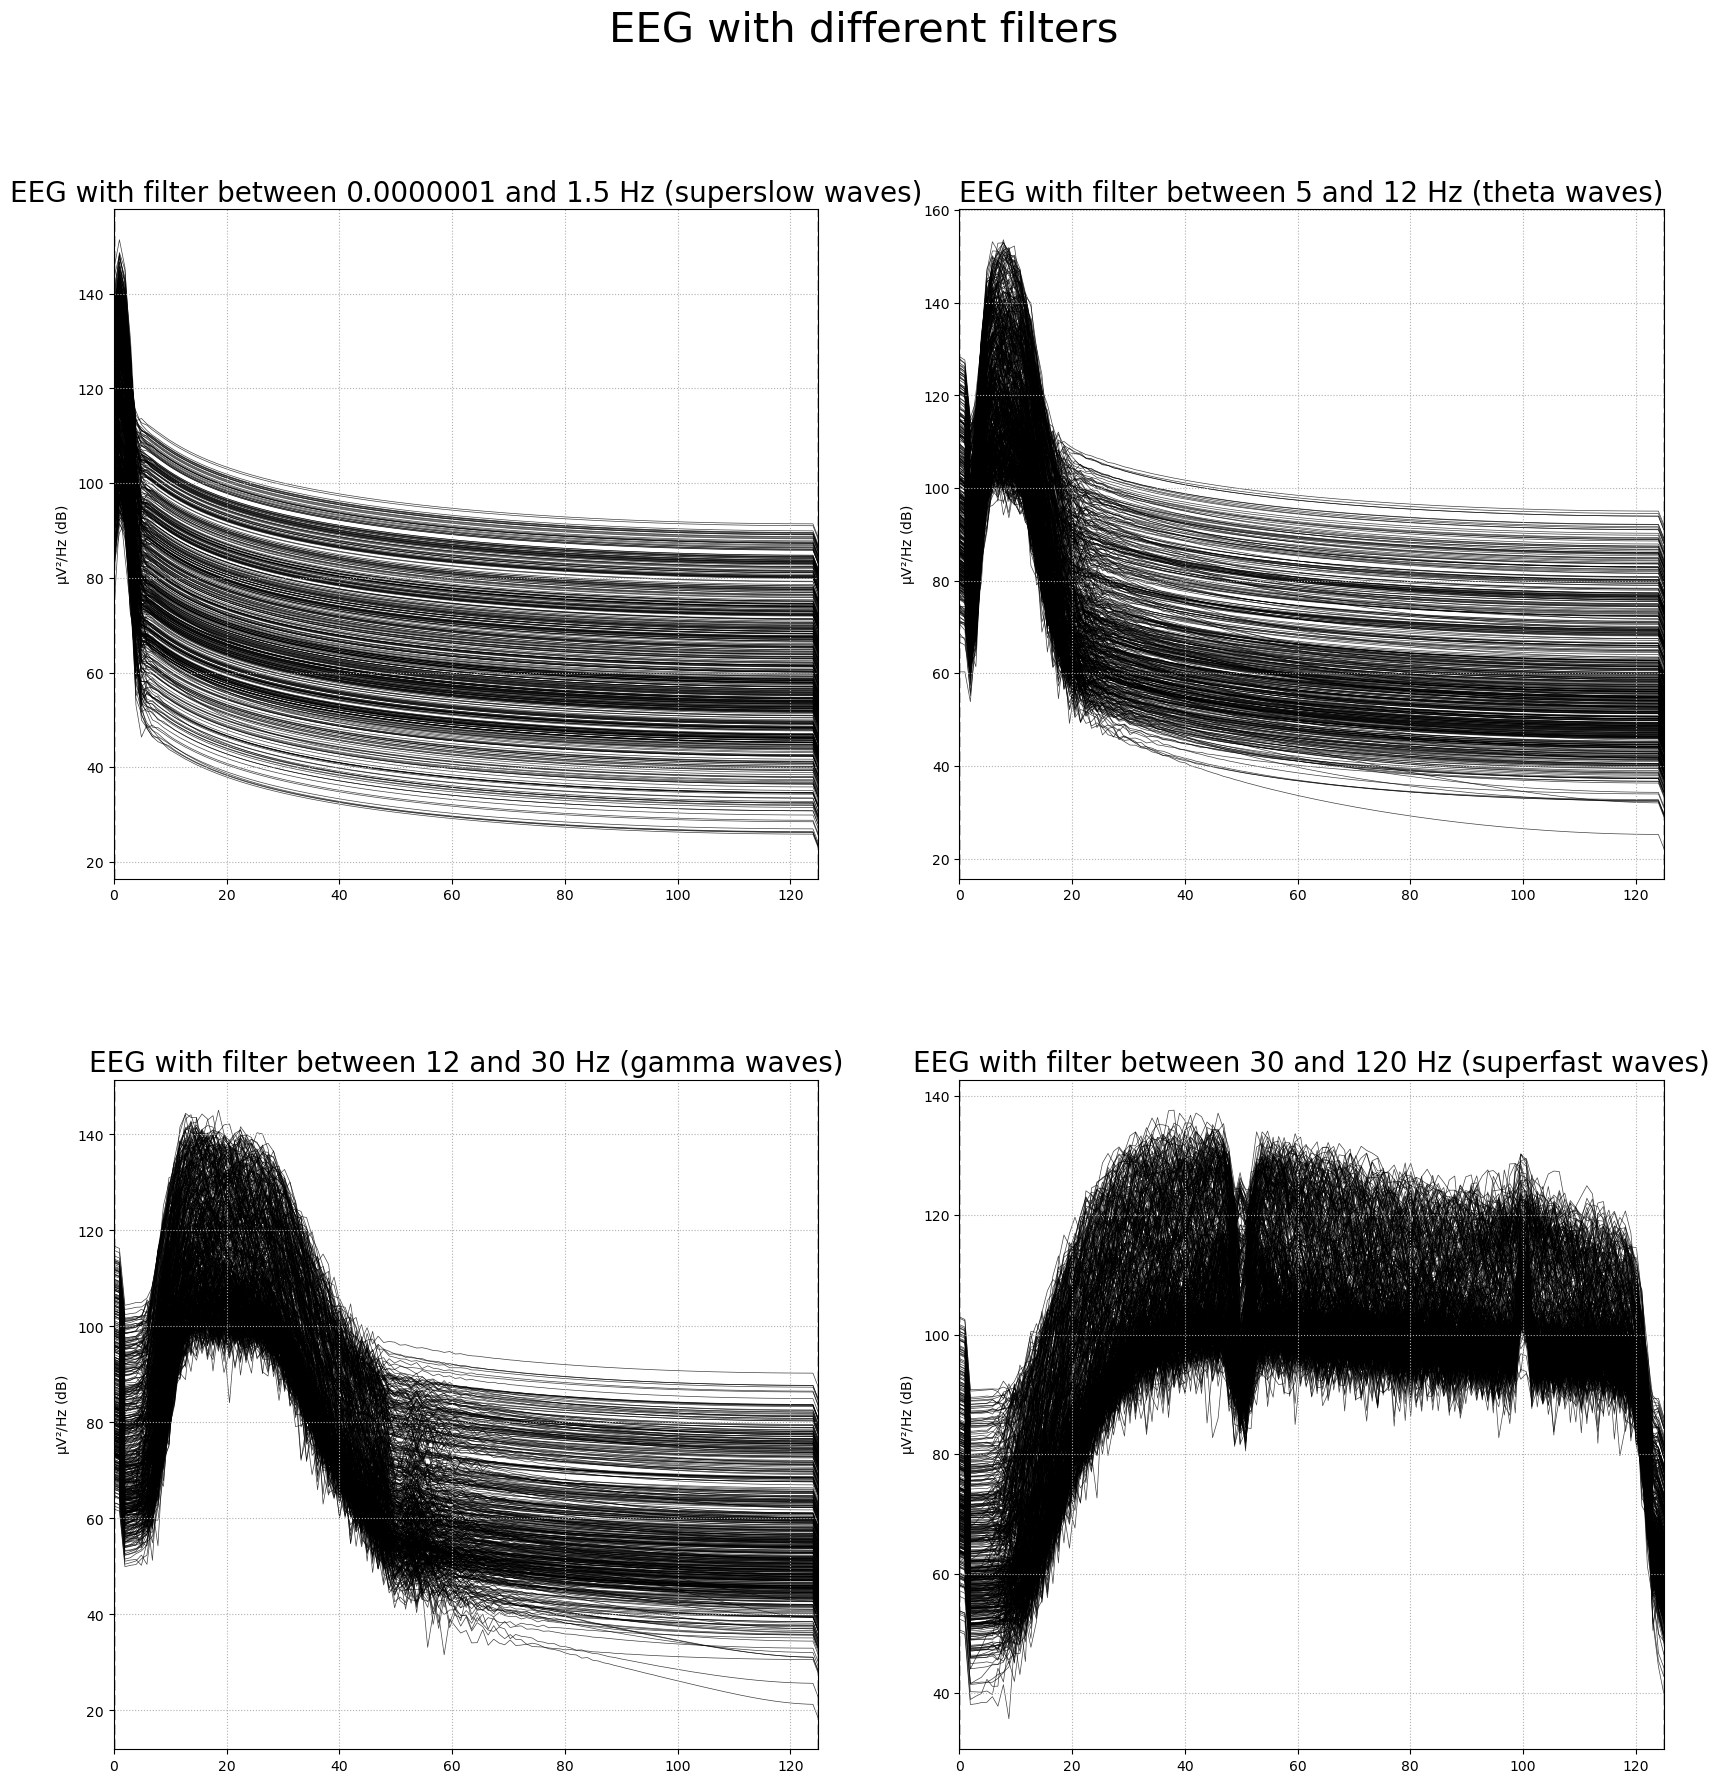

In [11]:
plt.close('all')
fig,ax = plt.subplots(2,2,figsize=(20,20))#,dpi=500)
data_f = filter_data(data,0.0000001,1.5, sampling_rate)
simulated_raw_filterd = mne.io.RawArray(data_f, info)
simulated_raw_filterd.plot_psd(ax=ax[0,0])
ax[0,0].set_title("EEG with filter between 0.0000001 and 1.5 Hz (superslow waves)",fontsize=20)

data_f = filter_data(data,5,12, sampling_rate)
simulated_raw_filterd = mne.io.RawArray(data_f, info)
simulated_raw_filterd.plot_psd(ax=ax[0,1])
ax[0,1].set_title("EEG with filter between 5 and 12 Hz (theta waves)",fontsize=20)

data_f = filter_data(data,12,30, sampling_rate)
simulated_raw_filterd = mne.io.RawArray(data_f, info)
simulated_raw_filterd.plot_psd(ax=ax[1,0])
ax[1,0].set_title("EEG with filter between 12 and 30 Hz (gamma waves)",fontsize=20)

data_f = filter_data(data,30,120, sampling_rate)
simulated_raw_filterd = mne.io.RawArray(data_f, info)
simulated_raw_filterd.plot_psd(ax=ax[1,1])
ax[1,1].set_title("EEG with filter between 30 and 120 Hz (superfast waves)",fontsize=20)

plt.suptitle("EEG with different filters",fontsize=30)
# plt.savefig("./figures/EEG_with_different_filters.png")
plt.show()

How to determine the dominant wave ?

## 3. Heatmap

### 3.1 Heatmap on the first part of the experiment (before the gap)

Effective window size : 1.024 (s)


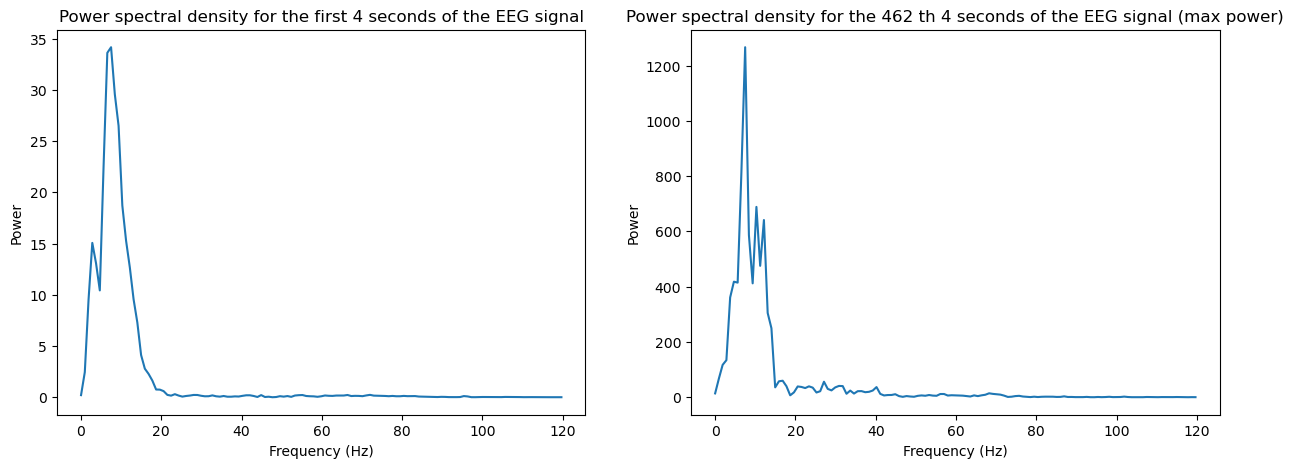

In [30]:
plt.close('all')
frequencies = np.arange(0, 120, 0.935)
# power = mne.time_frequency.psd_welch(
#     simulated_raw, 
#     fmin=0, 
#     fmax=120,
#     n_fft=1000, 
#     n_overlap=0, 
#     n_per_seg=1000,
#     n_jobs=1, 
#     verbose=None
#     ) # Compute the psd for all the slices of 4 seconds of the data
power = simulated_raw.compute_psd()

fig, ax = plt.subplots(1,2, figsize=(15,5))


ax[0].plot(frequencies, power[0][0], label='PSD')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Power')
ax[0].set_title('Power spectral density for the first 4 seconds of the EEG signal')

ax[1].plot(frequencies, power[462][0], label='PSD')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power')
ax[1].set_title('Power spectral density for the 462 th 4 seconds of the EEG signal (max power)')

plt.show()

### 3.2 plot the heatmap

To do the heatmap we need to have the a df like this :

time| 4 | 8 
---|---|---
freq |   power |  power
...  |   ...    | ...

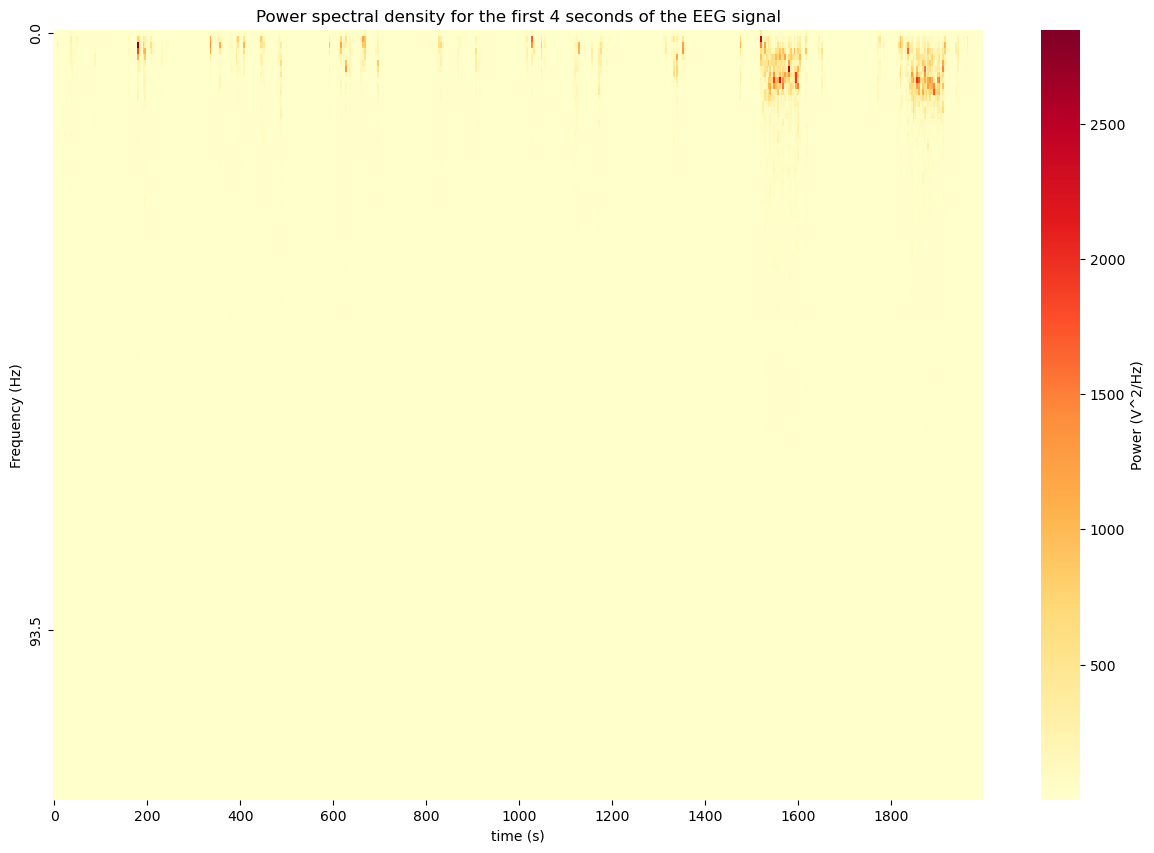

In [96]:
plt.close('all')
plt.figure(figsize=(15,10))#,dpi=500)
htmap = pd.DataFrame(power[0])
htmap = htmap.T
for i in range(1,500) : 
    htmap[i] = power[i][0]
htmap = htmap.rename(columns=dict((i,i*4) for i in range(500)))
htmap
htmap["freq"] = frequencies
htmap = htmap.set_index("freq", drop=True)
sns.heatmap(htmap, cmap="YlOrRd", xticklabels=50, yticklabels=100, cbar_kws={'label': 'Power (V^2/Hz)'})
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Power spectral density for the first 4 seconds of the EEG signal')
# plt.savefig("./figures/heatmap.png")
plt.show()

### 3.3 Set a threshold to the heatmap

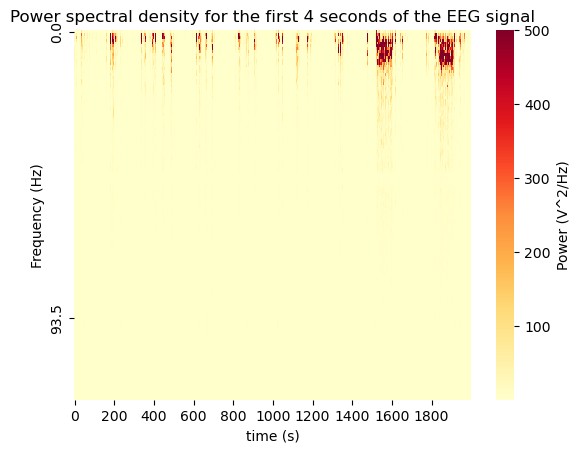

In [97]:
htmap[htmap > 500] = 500
sns.heatmap(htmap, cmap="YlOrRd", xticklabels=50, yticklabels=100, cbar_kws={'label': 'Power (V^2/Hz)'})
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Power spectral density for the first 4 seconds of the EEG signal')
# plt.savefig("./figures/heatmap.png")
plt.show()

Strange because we get only theta waves 

Should we apply a max value for the PSD ? bc 5000 is very huge

### 3.4 Zoom on the heatmap threshold  

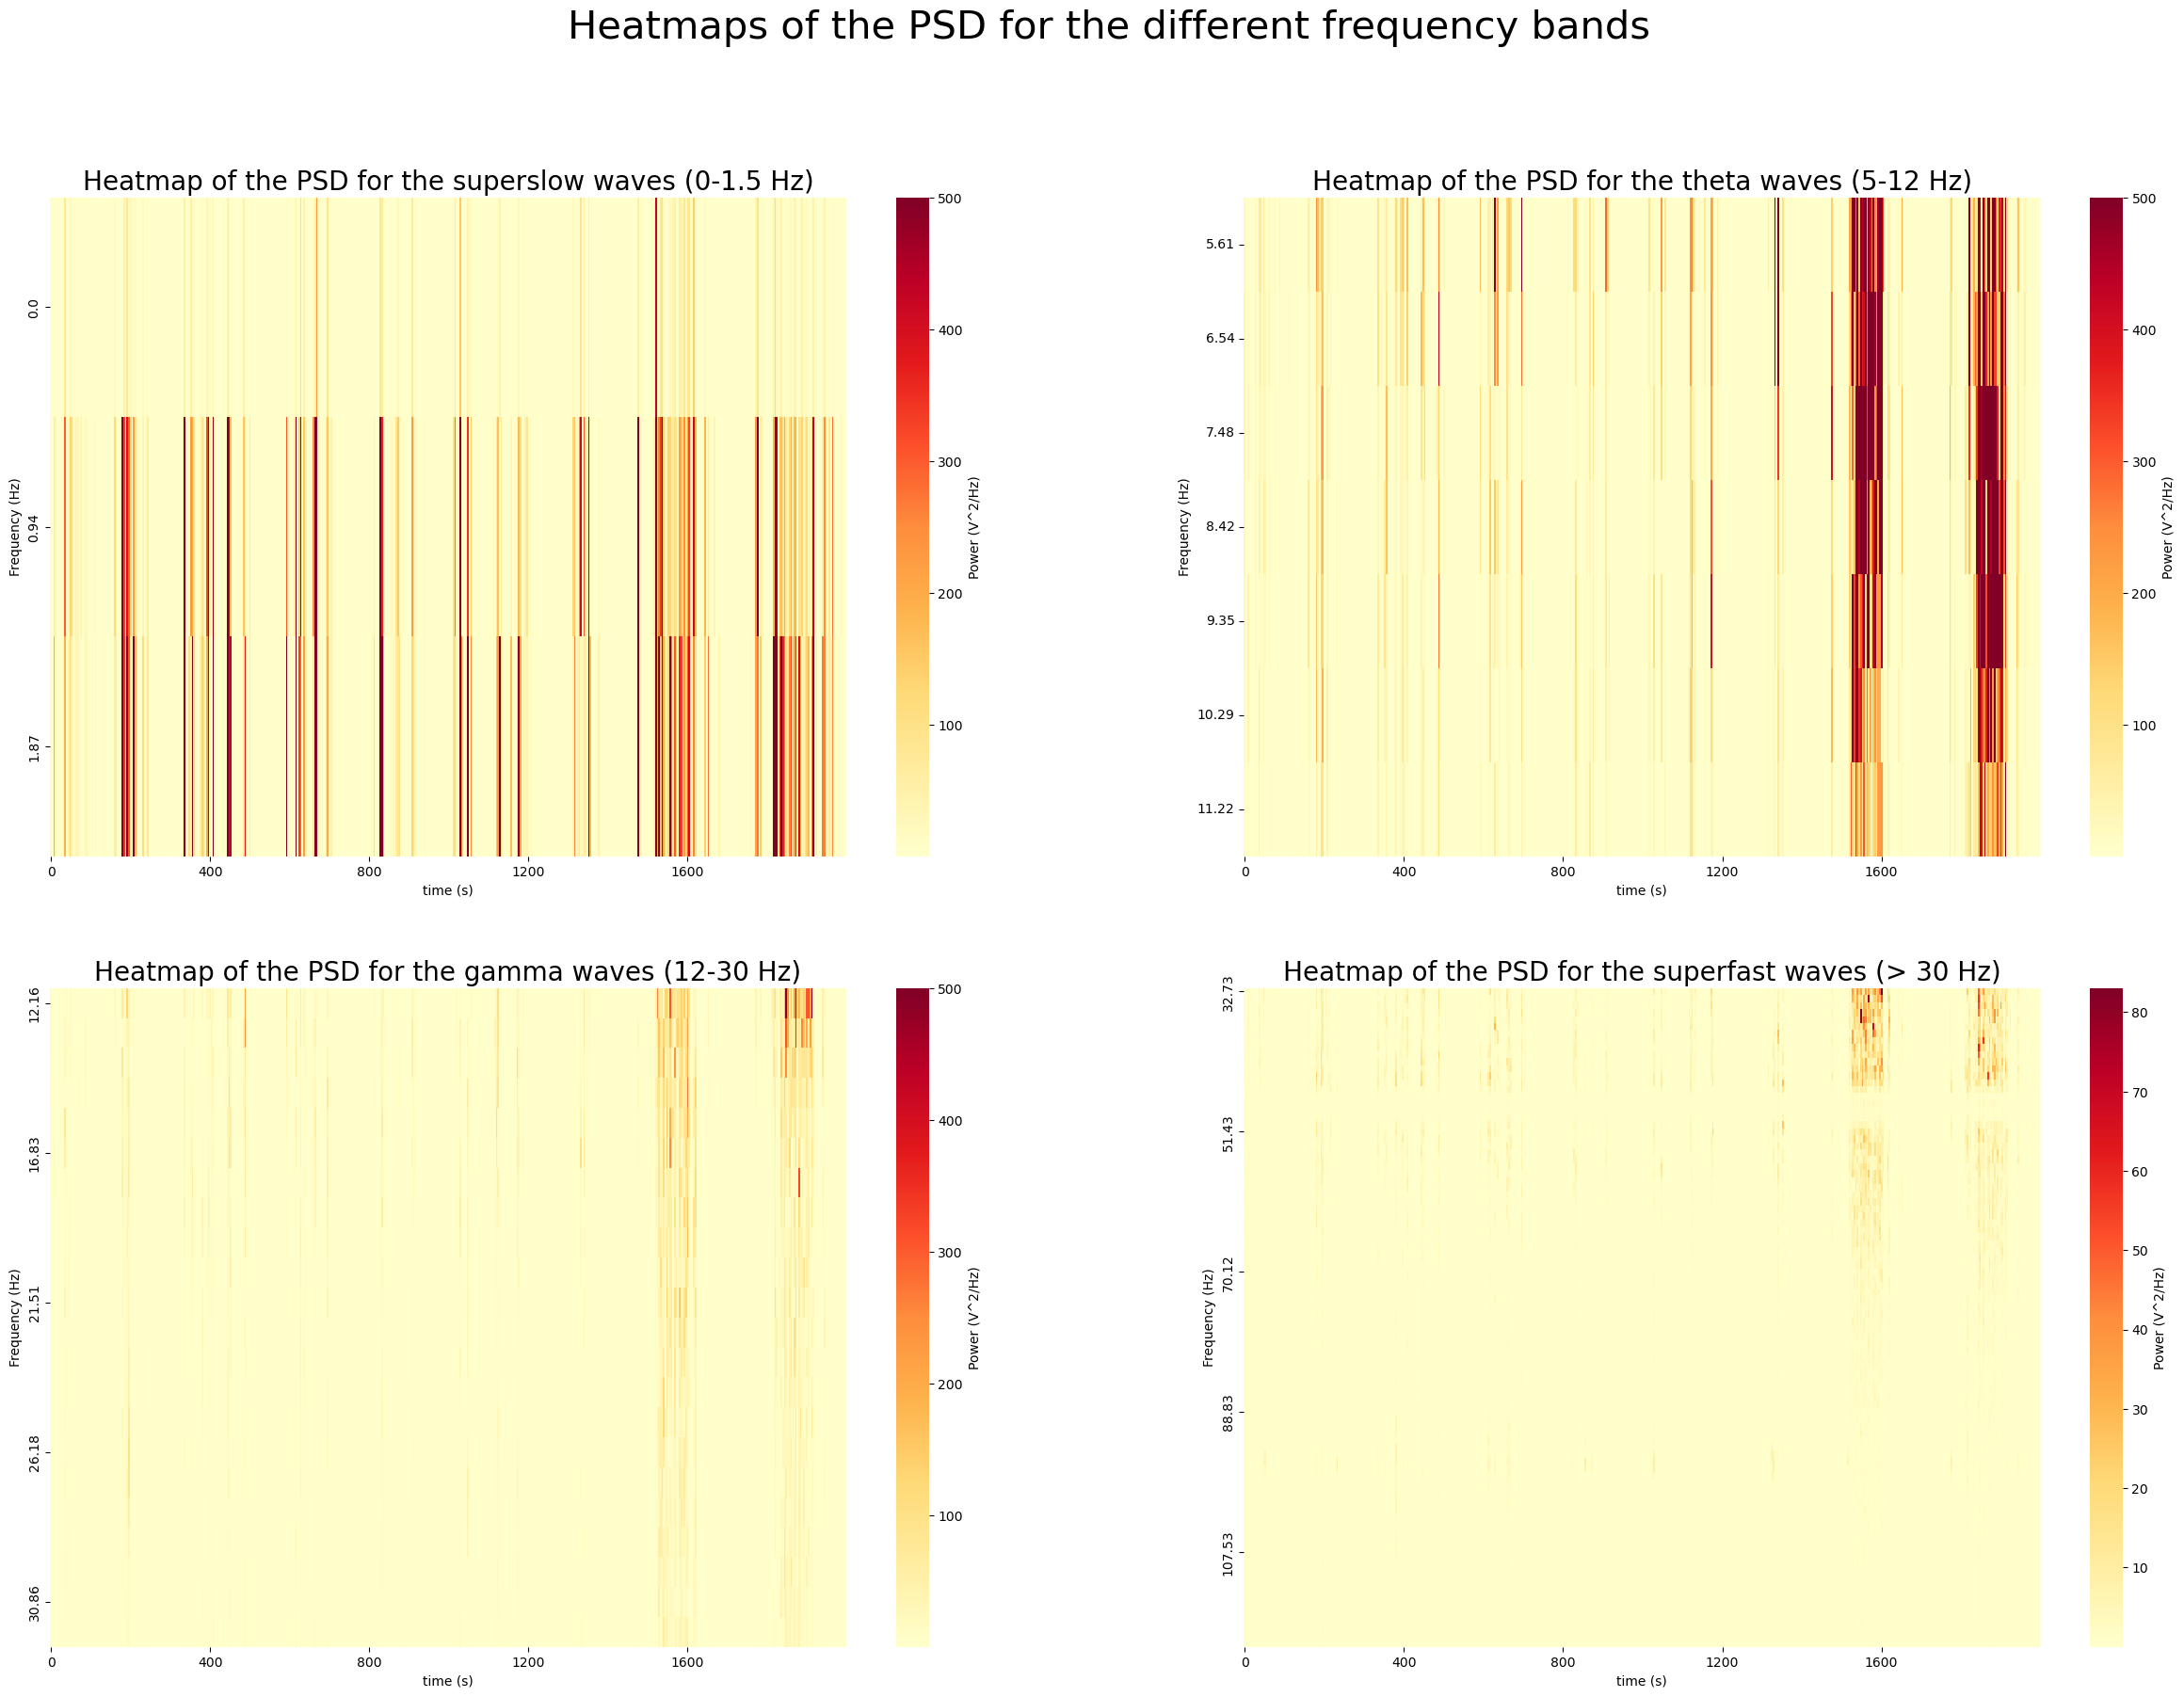

In [98]:
plt.close('all')
fig,ax = plt.subplots(2,2, figsize=(30,20))#,dpi=1000)

htmap_zoom = htmap.iloc[:3, :]
sns.heatmap(htmap_zoom, cmap="YlOrRd", xticklabels=100, yticklabels=1, cbar_kws={'label': 'Power (V^2/Hz)'}, ax=ax[0,0])
ax[0,0].set_xlabel('time (s)')
ax[0,0].set_ylabel('Frequency (Hz)')
ax[0,0].set_title('Heatmap of the PSD for the superslow waves (0-1.5 Hz)', fontsize=20)
labels = [item.get_text() for item in ax[0,0].get_yticklabels()]
ax[0,0].set_yticklabels([str(round(float(label), 2)) for label in labels])


htmap_zoom = htmap.iloc[6:13, :]
sns.heatmap(htmap_zoom, cmap="YlOrRd", xticklabels=100, yticklabels=1, cbar_kws={'label': 'Power (V^2/Hz)'}, ax=ax[0,1])
ax[0,1].set_xlabel('time (s)')
ax[0,1].set_ylabel('Frequency (Hz)')
ax[0,1].set_title('Heatmap of the PSD for the theta waves (5-12 Hz)', fontsize=20)
labels = [item.get_text() for item in ax[0,1].get_yticklabels()]
ax[0,1].set_yticklabels([str(round(float(label), 2)) for label in labels])

htmap_zoom = htmap.iloc[13:35, :]
sns.heatmap(htmap_zoom, cmap="YlOrRd", xticklabels=100, yticklabels=5, cbar_kws={'label': 'Power (V^2/Hz)'}, ax=ax[1,0])
ax[1,0].set_xlabel('time (s)')
ax[1,0].set_ylabel('Frequency (Hz)')
ax[1,0].set_title('Heatmap of the PSD for the gamma waves (12-30 Hz)', fontsize=20)
labels = [item.get_text() for item in ax[1,0].get_yticklabels()]
ax[1,0].set_yticklabels([str(round(float(label), 2)) for label in labels])

htmap_zoom = htmap.iloc[35:, :]
sns.heatmap(htmap_zoom, cmap="YlOrRd", xticklabels=100, yticklabels=20, cbar_kws={'label': 'Power (V^2/Hz)'}, ax=ax[1,1])
ax[1,1].set_xlabel('time (s)')
ax[1,1].set_ylabel('Frequency (Hz)')
ax[1,1].set_title('Heatmap of the PSD for the superfast waves (> 30 Hz)', fontsize=20)
labels = [item.get_text() for item in ax[1,1].get_yticklabels()]
ax[1,1].set_yticklabels([str(round(float(label), 2)) for label in labels])

plt.suptitle('Heatmaps of the PSD for the different frequency bands', fontsize=30)
# plt.savefig("./figures/zoom_heatmap.png")
plt.show()

/!\ Each heatmap has not the same scale